<a href="https://colab.research.google.com/github/jared-roussel/big-data-challenge/blob/main/amazon_music_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [73.0 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [2]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sparkDates").getOrCreate()

In [14]:
# Load in data
from pyspark import SparkFiles
music_url ="https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Music_v1_00.tsv.gz"
spark.sparkContext.addFile(music_url)
df = spark.read.csv(SparkFiles.get("amazon_reviews_us_Music_v1_00.tsv.gz"), sep="\t", header=True, inferSchema=True, timestampFormat="yyyy/MM/dd HH:mm:ss")
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   10140119|R3LI5TRP3YIDQL|B00TXH4OLC|     384427924|Whatever's for Us...|           Music|          5|            0|          0|   N|                Y|          Five Stars|Love this CD alon...| 2015-08-31|
|         US|   27664622|R3LGC3EKEG84PX|B00B6QXN6U|     831769051|Same Trailer Diff...|           Music|          5|    

In [15]:
# Show schema to confirm date type
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [20]:
#Remove duplicates and null values before importing into postgres
df = df.drop_duplicates()
df = df.dropna()
#df

In [23]:
#Make data fit schema
music_review_id = df.select(["review_id","customer_id","product_id","product_parent","review_date"])
music_review_id.show(10)

KeyboardInterrupt: ignored

In [24]:
music_products = df.select(["product_id","product_title"])
music_products.show()

KeyboardInterrupt: ignored

In [6]:
# Import date time functions
from pyspark.sql.functions import year

# Show the year for the date column
#df.select(year(df["date"])).show()

In [ ]:
# Save the year as a new column
df = df.withColumn("year", year(df['date']))
df.show()

+-----------+-------------------+----+----+----+
|    station|               date|prcp|tobs|year|
+-----------+-------------------+----+----+----+
|USC00519397|2010-01-01 00:00:00|0.08|  65|2010|
|USC00519397|2010-01-02 00:00:00| 0.0|  63|2010|
|USC00519397|2010-01-03 00:00:00| 0.0|  74|2010|
|USC00519397|2010-01-04 00:00:00| 0.0|  76|2010|
|USC00519397|2010-01-07 00:00:00|0.06|  70|2010|
|USC00519397|2010-01-08 00:00:00| 0.0|  64|2010|
|USC00519397|2010-01-09 00:00:00| 0.0|  68|2010|
|USC00519397|2010-01-10 00:00:00| 0.0|  73|2010|
|USC00519397|2010-01-11 00:00:00|0.01|  64|2010|
|USC00519397|2010-01-12 00:00:00| 0.0|  61|2010|
|USC00519397|2010-01-14 00:00:00| 0.0|  66|2010|
|USC00519397|2010-01-15 00:00:00| 0.0|  65|2010|
|USC00519397|2010-01-16 00:00:00| 0.0|  68|2010|
|USC00519397|2010-01-17 00:00:00| 0.0|  64|2010|
|USC00519397|2010-01-18 00:00:00| 0.0|  72|2010|
|USC00519397|2010-01-19 00:00:00| 0.0|  66|2010|
|USC00519397|2010-01-20 00:00:00| 0.0|  66|2010|
|USC00519397|2010-01

In [ ]:
# Find the average precipitation per year
averages = df.groupBy("year").avg()
averages.orderBy("year").select("year", "avg(prcp)").show()

+----+-------------------+
|year|          avg(prcp)|
+----+-------------------+
|2010|0.13852293920179035|
|2011| 0.1637348927875241|
|2012| 0.1163805668016194|
|2013|0.15554567502020986|
|2014|0.17855953372189803|
|2015|0.19919999999999985|
|2016|0.17984533591106822|
|2017|0.16592738752959774|
+----+-------------------+



In [ ]:
from pyspark.sql.functions import month
df.select(month(df['Date'])).show()

+-----------+
|month(Date)|
+-----------+
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
|          1|
+-----------+
only showing top 20 rows



In [ ]:
df = df.withColumn("month", month(df['date']))
df.head()

Row(station='USC00519397', date=datetime.datetime(2010, 1, 1, 0, 0), prcp=0.08, tobs=65, year=2010, month=1)

In [ ]:
maxes = df.groupBy("month").max()
maxes.orderBy("month").select("month", "max(prcp)").show()

+-----+---------+
|month|max(prcp)|
+-----+---------+
|    1|     8.81|
|    2|     5.04|
|    3|     6.38|
|    4|     6.25|
|    5|     4.07|
|    6|     4.43|
|    7|    11.53|
|    8|     4.81|
|    9|     6.83|
|   10|     4.47|
|   11|     8.06|
|   12|     6.42|
+-----+---------+



In [ ]:
# Import the summarized data to a pandas dataframe for plotting
# Note: If your summarized data is still too big for your local memory then your notebook may crash

pandas_df = maxes.orderBy("month").select("month", "max(prcp)").toPandas()
pandas_df.head()

,month,max(prcp)
0,1,8.81
1,2,5.04
2,3,6.38
3,4,6.25
4,5,4.07


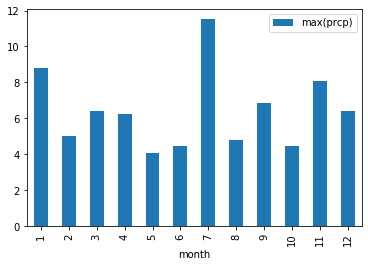

In [ ]:
import matplotlib.pyplot as plt
pandas_df.set_index("month", inplace=True)
pandas_df.plot.bar()